In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, callbacks
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, precision_score
import matplotlib.pyplot as plt
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Data directories
data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "valid")

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
batch_size = 128

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 56251 images belonging to 38 classes.
Found 14044 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [3]:
# Model architecture
model = keras.Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.3),
    Dense(4096, activation='relu'),
    Dropout(0.2),
    Dense(38, activation='softmax')
])

# Model summary
model.summary()

# Compile the model
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     1

In [4]:
# Train the model
early_stopping_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    min_lr=1e-7
)

checkpoint_cb = callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss'
)

epochs = 20

history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[early_stopping_cb, reduce_lr_cb, checkpoint_cb]
)


Epoch 1/20
440/440 [==============================] - 1463s 3s/step - loss: 3.8538 - accuracy: 0.0745 - val_loss: 3.5472 - val_accuracy: 0.0394 - lr: 0.0010
Epoch 2/20
440/440 [==============================] - 1167s 3s/step - loss: 3.0266 - accuracy: 0.1290 - val_loss: 4.8967 - val_accuracy: 0.0441 - lr: 0.0010
Epoch 3/20
440/440 [==============================] - ETA: 0s - loss: 2.5288 - accuracy: 0.2335
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
440/440 [==============================] - 1166s 3s/step - loss: 2.5288 - accuracy: 0.2335 - val_loss: 4.9437 - val_accuracy: 0.1479 - lr: 0.0010
Epoch 4/20
440/440 [==============================] - 1160s 3s/step - loss: 1.7414 - accuracy: 0.4480 - val_loss: 1.8817 - val_accuracy: 0.4031 - lr: 2.0000e-04
Epoch 5/20
440/440 [==============================] - 1164s 3s/step - loss: 1.3573 - accuracy: 0.5668 - val_loss: 1.6856 - val_accuracy: 0.4726 - lr: 2.0000e-04
Epoch 6/20
440/440 [=========================

In [5]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

138/138 [==============================] - 137s 994ms/step - loss: 0.3244 - accuracy: 0.9339
Test loss: 0.3244040906429291
Test accuracy: 0.9338720440864563


138/138 [==============================] - 56s 403ms/step
Confusion Matrix:
[[429   6   0 ...   0   0   0]
 [  2 471   0 ...   0   0   0]
 [  0   0 421 ...   0   2   0]
 ...
 [  0   0   0 ... 472   0   0]
 [  0   0   0 ...   0 442   0]
 [  0   0   0 ...   0   0 443]]


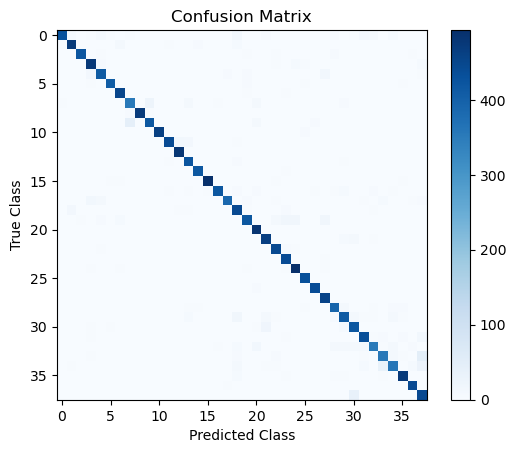

In [6]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# True labels for the test set
y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

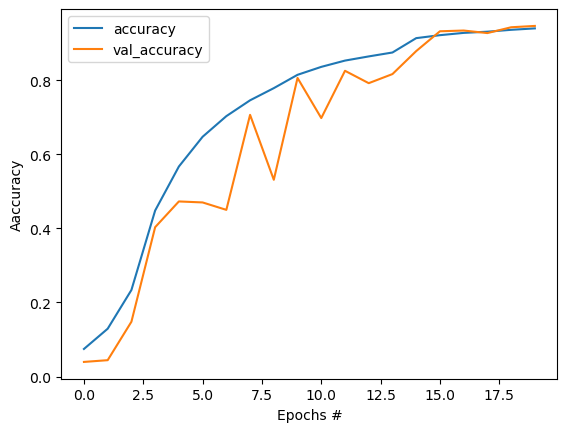

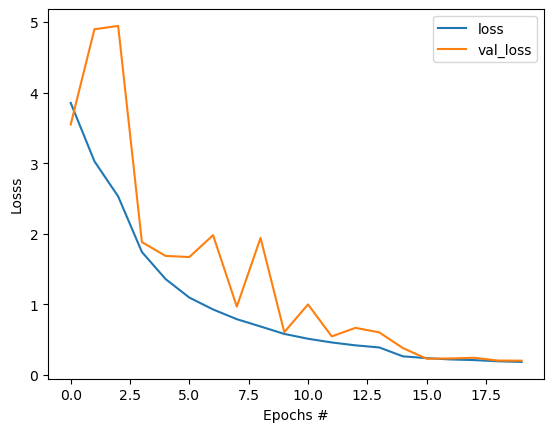

In [7]:
hist = history.history
def show_plt(type):
    if type == 1:
        plt.plot(hist["accuracy"], label="accuracy")
        plt.plot(hist["val_accuracy"], label="val_accuracy")
        plt.ylabel("Aaccuracy")
        plt.xlabel("Epochs #")
        plt.legend()
        plt.show()
    else:
        plt.plot(hist["loss"], label="loss")
        plt.plot(hist["val_loss"], label="val_loss")
        plt.ylabel("Losss")
        plt.xlabel("Epochs #")
        plt.legend()
        plt.show()
        
show_plt(1)
show_plt(0)

In [25]:
class_dict = test_generator.class_indices
print(class_dict)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [26]:
li = list(class_dict.keys())
print(li)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

Following is our prediction:
1/1 [==============================] - 0s 19ms/step


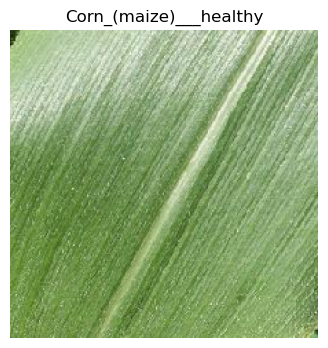

In [29]:
from tensorflow.keras.preprocessing import image
image_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Corn_(maize)___healthy/028ed539-32f5-4540-a6af-466179837de9___R.S_HL 8212 copy.jpg"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = model.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]
        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()